In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os
load_dotenv()
PROJECT_ROOT = os.getenv('PROJECT_ROOT')

# Add PROJECT_ROOT to the Python path
import sys
sys.path.append(PROJECT_ROOT)

# Load Navigation Graph

In [2]:
import networkx as nx

In [3]:
# Load the comprehensive route graph
import time 
time_start = time.time()
print('Reading navigation graph...')
import pickle
G = pickle.load(open(os.path.join(PROJECT_ROOT, 'data', 'graphs', 'ats_fra_graph.pkl'), 'rb'))
print(f'Navigation graph loaded in {time.time() - time_start:.2f} seconds')

Reading navigation graph...
Navigation graph loaded in 5.27 seconds


# Load the Routes

In [4]:
import pandas as pd 
routes_df = pd.read_csv(os.path.join(PROJECT_ROOT, 'data', 'routes_data', 'cs_2023-04-01.csv'))
# column names: id	from_time	to_time	from_lat	from_lon	to_lat	to_lon	from_alt	to_alt	from_speed	to_speed
routes_df.head()

,id,from_time,to_time,from_lat,from_lon,to_lat,to_lon,from_alt,to_alt,from_speed,to_speed
0,000042HMJ225,1.680349e+09,1.680365e+09,42.941666,14.271751,46.177048,14.543554,11521.44,1569.72,0.232055,0.139918
1,000042HMJ225,1.680365e+09,1.680383e+09,46.177048,14.543554,35.847458,14.489973,1569.72,114.30,0.139918,0.000000
2,001260TC T124,1.680347e+09,1.680347e+09,40.781622,26.631546,40.737488,26.461792,4297.68,4876.80,0.031492,0.031096
3,001260TC T124,1.680347e+09,1.680348e+09,40.737488,26.461792,40.717529,26.377625,4876.80,5242.56,0.031096,0.029558
4,001260TC T124,1.680348e+09,1.680348e+09,40.717529,26.377625,40.729298,26.257761,5242.56,5486.40,0.029558,0.046496


In [5]:
flight_ids = routes_df['id'].unique()
print(f'There are {len(flight_ids)} unique flight ids in the routes data')
selected_flight_id = '0100A3MSR560'
print(f'Selected flight id: {selected_flight_id}')
selected_flight_df = routes_df[routes_df['id'] == selected_flight_id]
print(f'Selected flight df: {selected_flight_df.head()}')

There are 23947 unique flight ids in the routes data
Selected flight id: 0100A3MSR560
Selected flight df:               id     from_time       to_time   from_lat   from_lon     to_lat  \
56  0100A3MSR560  1.680319e+09  1.680319e+09  34.798822  27.681713  34.909570   
57  0100A3MSR560  1.680319e+09  1.680325e+09  34.909570  27.617397  45.970614   
58  0100A3MSR560  1.680325e+09  1.680329e+09  45.970614  18.859474  50.442444   
59  0100A3MSR560  1.680329e+09  1.680330e+09  50.442444  10.632019  50.968183   
60  0100A3MSR560  1.680330e+09  1.680330e+09  50.968183   8.138351  50.937040   

       to_lon  from_alt    to_alt  from_speed  to_speed  
56  27.617397  12306.30  12306.30    0.227358  0.225809  
57  18.859474  12306.30  12047.22    0.225809  0.235399  
58  10.632019  12047.22   9570.72    0.235399  0.235305  
59   8.138351   9570.72   2926.08    0.235305  0.160455  
60   7.379074   2926.08    967.74    0.160455  0.082072  


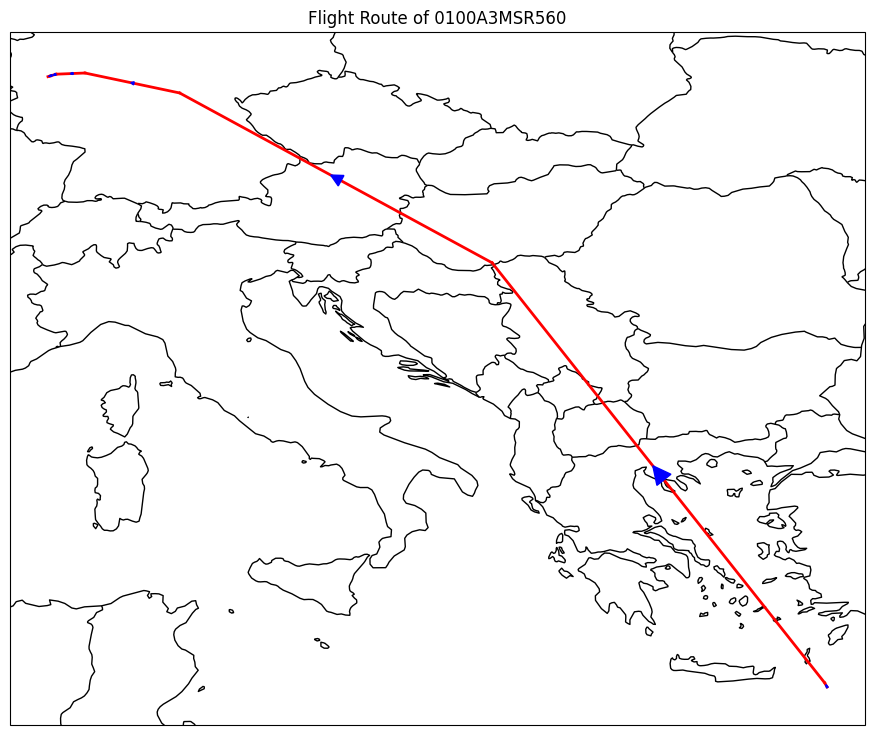

In [6]:
from utils.ploter import plot_route_of_flight
plot_route_of_flight(selected_flight_df, figsize=(12, 9))

In [7]:
from compute_routes import convert_df_to_segment_format
from infer_route import trim_mini_segments
selected_flight_route_full = convert_df_to_segment_format(selected_flight_df)
# Trim the mini segments
selected_flight_route = trim_mini_segments(selected_flight_route_full, min_length_nm=15.0)
print(f'Number of segments, before: {len(selected_flight_route_full)}, after: {len(selected_flight_route)}')

Number of segments, before: 7, after: 4


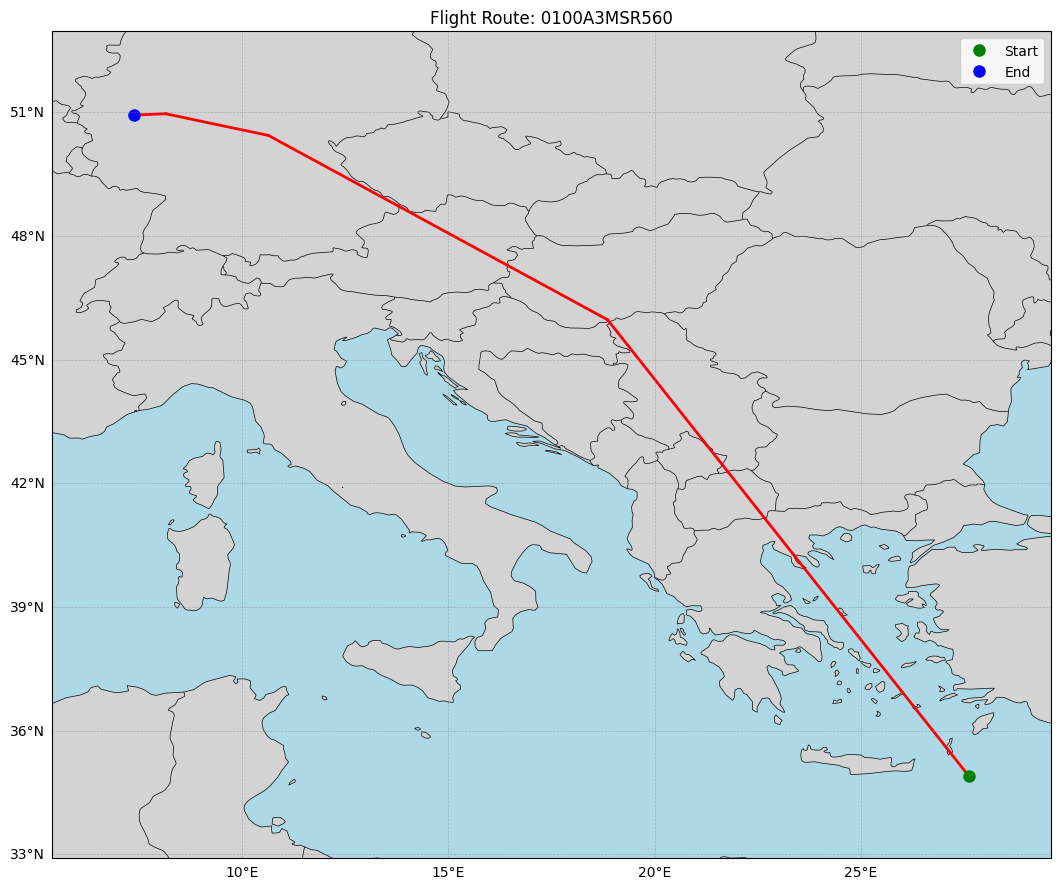

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

def plot_flight_route_with_cartopy(flight_segments, figsize=(12, 9), title=None):
    """
    Plot flight route segments using Cartopy.
    
    Parameters:
        flight_segments (list): List of dictionaries containing flight segment data
        figsize (tuple): Figure size (width, height) in inches
        title (str): Optional title for the plot
        
    Returns:
        matplotlib.figure.Figure: The figure object
    """
    # Create a new figure with a PlateCarree projection
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Collect all coordinates to determine map extent
    lats = []
    lons = []
    for segment in flight_segments:
        lats.extend([segment['from_lat'], segment['to_lat']])
        lons.extend([segment['from_lon'], segment['to_lon']])
    
    # Set map extent with some padding
    padding = 2.0  # degrees
    min_lon, max_lon = min(lons) - padding, max(lons) + padding
    min_lat, max_lat = min(lats) - padding, max(lats) + padding
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Plot each segment as a line
    for i, segment in enumerate(flight_segments):
        ax.plot([segment['from_lon'], segment['to_lon']], 
                [segment['from_lat'], segment['to_lat']], 
                'r-', linewidth=2, transform=ccrs.PlateCarree())
        
        # Plot start and end points
        if i == 0:  # First segment start point
            ax.plot(segment['from_lon'], segment['from_lat'], 'go', markersize=8, 
                    transform=ccrs.PlateCarree(), label='Start')
        
        if i == len(flight_segments) - 1:  # Last segment end point
            ax.plot(segment['to_lon'], segment['to_lat'], 'bo', markersize=8, 
                    transform=ccrs.PlateCarree(), label='End')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Add title if provided
    if title:
        plt.title(title)
    else:
        flight_id = flight_segments[0]['id']
        plt.title(f'Flight Route: {flight_id}')
    
    plt.legend()
    plt.tight_layout()
    
    return fig

# Plot the selected flight route
plot_flight_route_with_cartopy(selected_flight_route)
plt.show()


# Infer the Routes for this flight

In [9]:
from infer_route import convert_final_routes_to_waypoints, infer_n_routes

In [14]:
time_start = time.time()
candidate_routes = infer_n_routes(selected_flight_route, G, 0., candidate_limit=2, n_routes=1)
print(f'Inferred {len(candidate_routes)} routes in {time.time() - time_start:.2f} seconds')

Extracted relevant subgraph in 4.12 seconds
Computed candidate edges in 28.00 seconds
Adding edge ('TALAS', 'LAPSO_38') to beam with cost 1.9890944922244378
Adding edge ('ERANA', 'LAPSO_38') to beam with cost 1.9892508802889266
Adding edge ('KEROP_00', 'RAPET') to route [('TALAS', 'LAPSO_38'), ('KEROP_00', 'RAPET')] with cost 3.916771531533687
Adding edge ('KEROP_00', 'VARIK') to route [('TALAS', 'LAPSO_38'), ('KEROP_00', 'VARIK')] with cost 3.9167723680723663
Adding edge ('KEROP_00', 'RAPET') to route [('ERANA', 'LAPSO_38'), ('KEROP_00', 'RAPET')] with cost 3.9169279195981757
Adding edge ('KEROP_00', 'VARIK') to route [('ERANA', 'LAPSO_38'), ('KEROP_00', 'VARIK')] with cost 3.916928756136855
Adding edge ('TESDU', 'DODEN') to route [('TALAS', 'LAPSO_38'), ('KEROP_00', 'RAPET'), ('TESDU', 'DODEN')] with cost 5.711057744559721
Adding edge ('GASKA', 'DODEN') to route [('TALAS', 'LAPSO_38'), ('KEROP_00', 'RAPET'), ('GASKA', 'DODEN')] with cost 5.7268477188241995
Adding edge ('DIXAT', 'BERX

In [24]:
simplified_routes = [x for _, x in candidate_routes]
waypoints = [convert_final_routes_to_waypoints(x) for x in simplified_routes]

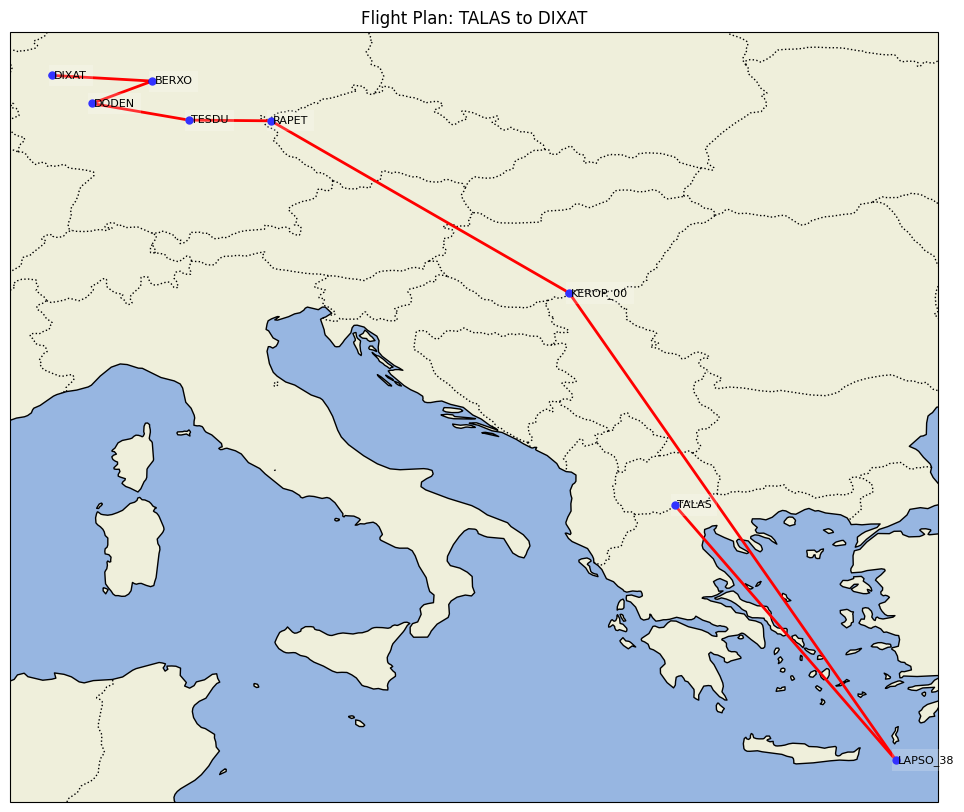

In [25]:
from utils.ploter import plot_flightplan2
plot_flightplan2(G, waypoints[0])

In [ ]:
# Find the successor nodes
node = 'ABNUR'
successors = list(G.neighbors(node))
print("Successor nodes of ABNUR:", successors)
